In [1]:
reset -sf

In [2]:
import sys
import os
import numpy as np 
import pandas as pd
from pathlib import Path

# univariate mlp example
from numpy import array

from keras import optimizers
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Conv1D, \
MaxPooling1D, Flatten, Dropout, GlobalMaxPooling1D,Input,Concatenate,Merge, concatenate

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.externals import joblib 
import matplotlib.pyplot as plt

/home/administrador/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/administrador/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/administrador/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/administrador/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/administrador/anaconda3/lib/python3.6/importlib/_bo

In [3]:
PATH = Path("../../data/")

In [4]:
dfX_Train = np.load(PATH/'train_x.npy')
dfX_Val = np.load(PATH/'val_x.npy') 
dfX_Test = np.load(PATH/'test_x.npy')
dfY_Train = np.load(PATH/'train_y.npy')
dfY_Val = np.load(PATH/'val_y.npy')
dfY_Test = np.load(PATH/'test_y.npy')
print(dfX_Train.shape, dfY_Train.shape)
print(dfX_Val.shape, dfY_Val.shape)
print(dfX_Test.shape, dfY_Test.shape)
print(dfX_Train[0,:10])

(8126, 2500) (8126, 1250)
(1016, 2500) (1016, 1250)
(1016, 2500) (1016, 1250)
[1.0743 1.0802 1.1212 1.2092 1.35   1.5396 1.7664 2.0088 2.2473 2.4399]


In [5]:
history=None
freq = 125
ini = 0 #freq
dim = freq * 2
ecg = 1250

In [6]:
trainY_n = dfY_Train[:,ini:ini+dim]
valY_n = dfY_Val[:,ini:ini+dim]
testY_n = dfY_Test[:,ini:ini+dim]

In [7]:
trainX_0_n = dfX_Train [:,ini:ini+dim]
trainX_1_n = dfX_Train [:,ini+ecg:ini+ecg+dim]

valX_0_n =dfX_Val [:,ini:ini+dim]
valX_1_n = dfX_Val[:,ecg+ini:ini+ecg+dim]

testX_0_n = dfX_Test[:,ini:ini+dim]
testX_1_n = dfX_Test[:,ecg+ini:ini+ecg+dim]

trainX_n = np.stack((trainX_0_n, trainX_1_n), axis=2)
valX_n = np.stack((valX_0_n,valX_1_n), axis=2)
testX_n = np.stack((testX_0_n, testX_1_n), axis=2)

print(trainX_n.max(), trainX_n.min(), trainX_n.std())
print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

4.5 -3.498 0.8156937694160916
(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [8]:
# Standardize

In [9]:
scaler_ppg = StandardScaler().fit(trainX_n[:,:,0])
scaler_ecg = StandardScaler().fit(trainX_n[:,:,1])
print(scaler_ppg.mean_.shape)
print(scaler_ecg.mean_.shape)

(250,)
(250,)


In [10]:
trainX_n = np.stack((scaler_ppg.transform(trainX_n[:,:,0]).reshape(-1,dim), scaler_ecg.transform(trainX_n[:,:,1]).reshape(-1,dim)), axis=2)
valX_n = np.stack((scaler_ppg.transform(valX_n[:,:,0]).reshape(-1,dim), scaler_ecg.transform(valX_n[:,:,1]).reshape(-1,dim)), axis=2)
testX_n = np.stack((scaler_ppg.transform(testX_n[:,:,0]).reshape(-1,dim), scaler_ecg.transform(testX_n[:,:,1]).reshape(-1,dim)), axis=2)

print(trainX_n.max(), trainX_n.min(), trainX_n.std())
print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

12.232114683629453 -11.461019164899536 1.0000000000000004
(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [22]:
input_tensor_y = Input(shape=(dim, 1))

input_tensor_x = Input(shape=(dim, 1))

x = Conv1D(filters=64, kernel_size=7, activation='relu')(input_tensor_x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(filters=128, kernel_size=7, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(filters=256, kernel_size=7, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(filters=512, kernel_size=7, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

y = Conv1D(filters=64, kernel_size=7, activation='relu')(input_tensor_y)
y = BatchNormalization()(y)
y = MaxPooling1D(pool_size=2)(y)
y = Dropout(0.3)(y)

y = Conv1D(filters=128, kernel_size=7, activation='relu')(y)
y = BatchNormalization()(y)
y = MaxPooling1D(pool_size=2)(y)
y = Dropout(0.3)(y)

y = Conv1D(filters=256, kernel_size=7, activation='relu')(y)
y = BatchNormalization()(y)
y = MaxPooling1D(pool_size=2)(y)
y = Dropout(0.3)(y)

y = Conv1D(filters=512, kernel_size=7, activation='relu')(y)
y = BatchNormalization()(y)
y = MaxPooling1D(pool_size=2)(y)
y = Dropout(0.3)(y)

merged = concatenate([x,y])
result = Flatten()(merged)
result = Dense(10240)(result)
result = BatchNormalization()(result)
result = Dropout(0.5)(result)
result = Dense(dim,)(result)

model = Model([input_tensor_x, input_tensor_y], result)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 250, 1)       0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 250, 1)       0                                            
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 244, 64)      512         input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 244, 64)      512         input_11[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [23]:
# fit model
model.compile(optimizer=optimizers.Adam(lr=1e-3), loss='mae')
history_prev = history
history = model.fit([np.expand_dims(trainX_n[:,:,0],2),np.expand_dims(trainX_n[:,:,1],2)], trainY_n, 
                     validation_data=([np.expand_dims(valX_n[:,:,0],2),np.expand_dims(valX_n[:,:,1],2)], valY_n), 
                     batch_size=64, epochs=10, verbose=1)

Train on 8126 samples, validate on 1016 samples
Epoch 1/10
8126/8126 [==============================] - 31s 4ms/step - loss: 65.5630 - val_loss: 38.8478
Epoch 2/10
8126/8126 [==============================] - 23s 3ms/step - loss: 18.2703 - val_loss: 19.6062
Epoch 3/10
8126/8126 [==============================] - 23s 3ms/step - loss: 16.9825 - val_loss: 19.1789
Epoch 4/10
8126/8126 [==============================] - 23s 3ms/step - loss: 15.6015 - val_loss: 18.2465
Epoch 5/10
8126/8126 [==============================] - 23s 3ms/step - loss: 15.0533 - val_loss: 16.3342
Epoch 6/10
8126/8126 [==============================] - 23s 3ms/step - loss: 14.4400 - val_loss: 15.5398
Epoch 7/10
8126/8126 [==============================] - 23s 3ms/step - loss: 13.8688 - val_loss: 15.9696
Epoch 8/10
8126/8126 [==============================] - 23s 3ms/step - loss: 13.5330 - val_loss: 14.5598
Epoch 9/10
8126/8126 [==============================] - 23s 3ms/step - loss: 13.1961 - val_loss: 14.5442
Epoch 1

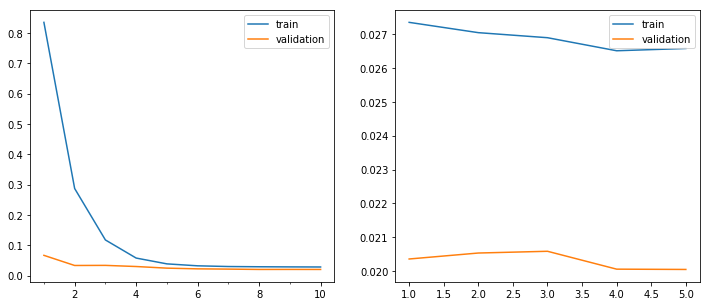

In [42]:
plt.figure(figsize=(12,5))
for i in range(2):
    if i == 0:
        if history_prev is None:
            continue
        else:
            hist = history_prev
    else:
        hist = history
        
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(1, len(loss) +1)
    ax = plt.subplot(1,2,1+i)
    ax.plot(epochs, loss, label="train")
    ax.plot(epochs, val_loss, label="validation")
    ax.set_xticks(epochs, epochs)
    ax.legend()

plt.show()

In [ ]:
# Save the weights and architecture

In [41]:
model.save_weights('conv1d_concat.h5')
with open('conv1d_concat.json', 'w') as f:
    f.write(model.to_json())

In [12]:
model.load_weights('conv1d_concat.h5')

In [13]:
#Evaluation
y_pred = []
for ix in range(testX_n.shape[0]):
    y_pred.append(model.predict([np.expand_dims(testX_n[ix,:,0].reshape(1,250),2),
                            np.expand_dims(testX_n[ix,:,1].reshape(1,250),2)]))

In [14]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

y_pred = np.array(y_pred).reshape(-1,250)
print(y_pred.shape, testY_n.shape)
print("Test error analysis:")
print("Explained variance score:", explained_variance_score(testY_n, y_pred))
print("MAE error:", mean_absolute_error(testY_n, y_pred))
print("MSE error:", mean_squared_error(testY_n, y_pred))
print("R2 score:", r2_score(testY_n, y_pred))

(1016, 250) (1016, 250)
Test error analysis:
Explained variance score: 0.7405851596696389
MAE error: 0.11216855481728426
MSE error: 0.02594270014768813
R2 score: 0.735564680672521


(1, 250, 2)


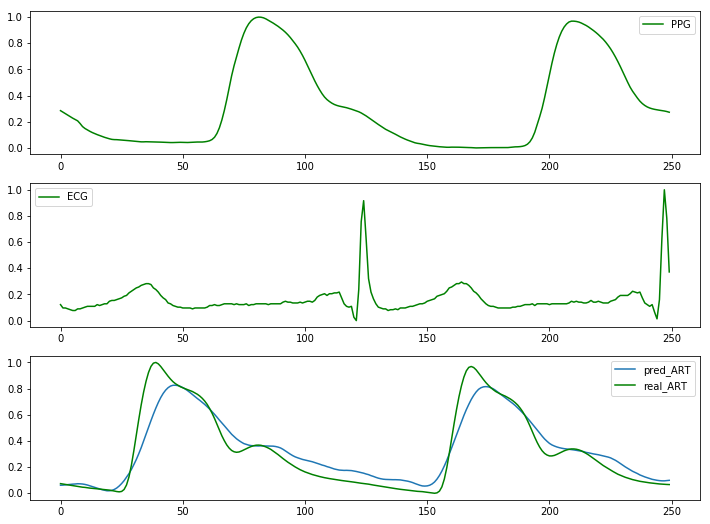

In [15]:
#Example
ix=10
print(np.expand_dims(testX_n[ix,:], axis=0).shape)

plt.figure(figsize=(12,9))
ax = plt.subplot(3,1,1)
ax.plot(testX_0_n[ix,:].reshape(1,-1).T, c="g", label="PPG")
ax.legend()

ax = plt.subplot(3,1,2)
ax.plot(testX_1_n[ix,:].reshape(1,-1).T, c="g", label="ECG")
plt.legend()

#Predicted vs real
ax = plt.subplot(3,1,3)
ax.plot(model.predict([np.expand_dims(testX_n[ix,:,0].reshape(1,250),2),
                        np.expand_dims(testX_n[ix,:,1].reshape(1,250),2)]).T, label="pred_ART")
ax.plot(testY_n[ix,:].reshape(1,-1).T, c="g", label="real_ART")
ax.legend()
plt.show()